**Data not available, this file only serves as an illustration.**

Beware, if you run the cells, you will get errors and will loose the images.
To avoid this problem, you could replace the input data names.

In [9]:
import glob
import sys
import os.path
sys.path.append('../')
sys.path.append('../../')
from pyLAR import *
import SimpleITK as sitk
import Image

In [10]:
# global parameters
EXE_ConvertToJpg = '~/work/bin/ANTS/bin/ConvertToJpg'
data_folder = '/Users/xiaoxiaoliu/work/data/Face/testFem_10'
input_folder = data_folder +'/inputs'
result_folder = data_folder +'/LRA_Results'
UAB_result_folder = data_folder +'/UAB_Results'
os.system('mkdir '+ result_folder)
os.system('mkdir '+ UAB_result_folder)

im_names = glob.glob(input_folder+'/*.*')
num_of_data = len(im_names)
x_dim = 86
y_dim = 86

# data selection
selection = [0,1,2,3,4,5,6,7,8,9]  
num_of_data = len(selection)


NUM_OF_ITERATIONS = 10

In [11]:
def getImageArray(fn, CONVERT= False):
    if CONVERT:
        img = Image.open(fn).convert('LA')
        newImFn = os.path.splitext(fn)[0]+'.png'
        img.save(newImFn)
        convertToJpg(newImFn)
        os.system('rm '+newImFn)
        newImFn = os.path.splitext(fn)[0]+'.jpg'
        fn = newImFn
    
    im = sitk.ReadImage(fn)
    im_array = sitk.GetArrayFromImage(im)
    return im_array

def convertToJpg(fn):
    outputFn = os.path.splitext(fn)[0]+'.jpg'
    cmd = EXE_ConvertToJpg + ' ' + fn + ' ' + outputFn
    os.system(cmd)
    return outputFn

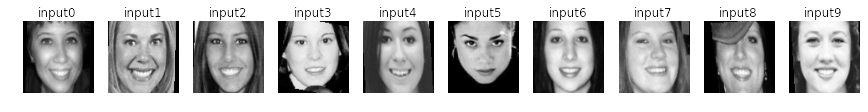

In [12]:
plt.figure(figsize=(15,5)) 

for i in range(num_of_data):
        fn = im_names[selection[i]]
        im_array = getImageArray(fn)
        plt.subplot(1,num_of_data,i+1)
        implot = plt.imshow(im_array,cm.gray) 
        plt.title('input'+str(i))
        plt.axis('off')  
        iter0Fn = result_folder+'/Input_'+str(i)+'.nrrd'
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,iter0Fn)

Affine registration results:


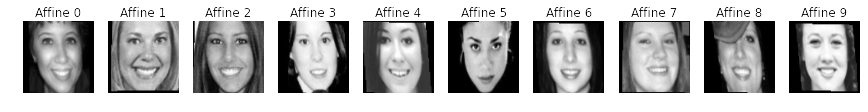

In [13]:
# Testing ANTS affine registration, set parameters    
print 'Affine registration results:'
plt.figure(figsize=(15,5)) 
fixedIm =  result_folder+'/Input_'+str(2)+'.nrrd'
for i in range(num_of_data):
    movingIm= result_folder+'/Input_'+str(i)+'.nrrd'
    antsParams =  {
'Dimension': 2,\
'Convergence' : '[1000x1000,1e-6,5]',\
'ShrinkFactors' : '2x1',\
'SmoothingSigmas' : '2x0vox',\
'Transform' :'Affine[0.25]',\
'Metric': 'CC[%s,%s,1,8]' %(fixedIm, movingIm)
#'Metric': 'Mattes[%s,%s,1,50]' %(fixedIm, movingIm)
}
    ANTS(fixedIm, movingIm,result_folder+'/affine',antsParams, None, True)
    warpedImFn = result_folder+ '/affineWarped.nrrd'
    affineFn = result_folder+'/affine_'+str(i)+'.nrrd'
    os.system('cp '+warpedImFn+' '+affineFn)
    
    im_array = getImageArray(affineFn)
    plt.subplot(1,num_of_data,i+1)
    implot = plt.imshow(im_array,cm.gray) 
    plt.axis('off')
    plt.title('Affine '+str(i))



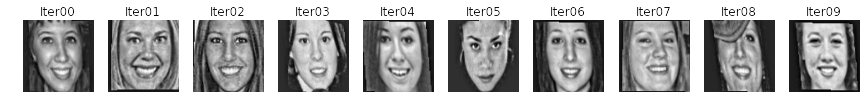

In [28]:
# preprocessing: normalize intensity distribution
plt.figure(figsize=(15,5)) 
#fixedIm =  result_folder+'/affine_'+str(0)+'.nrrd'
for i in range(num_of_data):
    affineFn = result_folder+'/affine_'+str(i)+'.nrrd'
    iter0Fn = result_folder+'/Iter0_'+str(i)+'.nrrd'
    hmfilter = sitk.AdaptiveHistogramEqualizationImageFilter()
    hmfilter.SetAlpha(0.6)
    hmfilter.SetBeta(0.6)
    #hmfilter.SetRadius(30)
    inIm = sitk.ReadImage(affineFn)
    #refIm = sitk.ReadImage(fixedIm) 
    im = hmfilter.Execute(inIm)
    sitk.WriteImage(im, iter0Fn)
    im_array = sitk.GetArrayFromImage(im)
    plt.subplot(1,num_of_data,i+1)
    implot = plt.imshow(im_array,cm.gray) 
    plt.axis('off')
    plt.title('Iter0'+str(i))



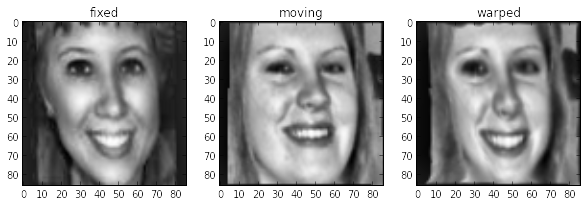

In [15]:
# Testing ANTS registration, set parameters
fixedIm =  result_folder+'/Iter0_'+str(0)+'.nrrd'
movingIm =  result_folder+'/Iter0_'+str(7)+'.nrrd'

antsParams =  {
'Dimension': 2,\
'Convergence' : '[200x100,1e-6,10]',\
'ShrinkFactors' : '2x1',\
'SmoothingSigmas' : '1x0vox',\
'Transform' :'SyN[0.1,1,0]',\
#'Metric': 'Mattes[%s,%s,1,50]' %(fixedIm, movingIm)
#'Metric': 'CC[fixedIm,movingIm,1,5]' # the file name will be replaced inside the ANTS()
'Metric': 'MeanSquares[fixedIm,movingIm,1,0]'
}
# Mattes[f,m ,weight, histogramb_in_size,samplingmethod, samplingPercentage]     
#'Metric': 'Mattes[%s,%s,1,50]' %(fixedIm, movingIm)}

cmd = ANTS(fixedIm, movingIm,result_folder+'/test',antsParams)
#print cmd
os.system(cmd)
warpedImFn = result_folder+ '/testWarped.nrrd'
#warpedImFn = convertToJpg(warpedImFn)

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.title('fixed')
plt.imshow(getImageArray(fixedIm),cm.gray) 
plt.subplot(132)
plt.title('moving')
plt.imshow(getImageArray(movingIm),cm.gray) 
plt.subplot(133)
plt.title('warped')
plt.imshow(getImageArray(warpedImFn),cm.gray) 


[iter: 0000]: rank(P) = 0002, |C|_0 = 18757, crit=0.2204519911, total sparse =792416
[iter: 0010]: rank(P) = 0004, |C|_0 = 66115, crit=0.0025877727, total sparse =1885140
[iter: 0020]: rank(P) = 0004, |C|_0 = 70812, crit=0.0000183267, total sparse =1886449
[iter: 0030]: rank(P) = 0004, |C|_0 = 71238, crit=0.0000002742, total sparse =1886367
RPCA takes:0.208036 seconds
[iter: 0000]: rank(P) = 0002, |C|_0 = 0301, crit=0.2543051009, total sparse =2700
[iter: 0010]: rank(P) = 0010, |C|_0 = 45593, crit=0.0009110427, total sparse =1152757
[iter: 0020]: rank(P) = 0010, |C|_0 = 43763, crit=0.0000002180, total sparse =1108282
RPCA takes:0.148832 seconds
[iter: 0000]: rank(P) = 0002, |C|_0 = 0000, crit=0.2547638380, total sparse =0000
[iter: 0010]: rank(P) = 0010, |C|_0 = 20671, crit=0.0006979746, total sparse =486924
[iter: 0020]: rank(P) = 0010, |C|_0 = 19753, crit=0.0000001223, total sparse =461663
RPCA takes:0.145466 seconds
[iter: 0000]: rank(P) = 0002, |C|_0 = 0000, crit=0.2547638380, tota

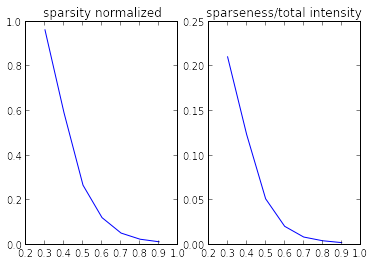

In [16]:
# Testing low-rank on original inputs to adjust lamda value
Y = np.zeros((x_dim*y_dim,num_of_data))
#print num_of_data

for i in range(num_of_data):
    fn = result_folder+'/Iter0_'+str(i)+'.nrrd'
    im_array = getImageArray(fn)
    #print im_array.shape
    Y[:,i] = im_array.reshape(-1)   
    
# choose lamda
lamdaList = arange(0.3,0.9,0.1)
s1 = [0] *len(lamdaList)
s2 = [0] *len(lamdaList)

for i in  range(len(lamdaList)):
  g = lamdaList[i]
  low_rank, sparse, n_iter,rank, sparsity ,sparseness= rpca(Y,g) 
  s1[i]= float(sparsity)/x_dim/y_dim/num_of_data
  s2[i]= float(sparseness)/sum(Y)

plt.figure()
plt.subplot(1,2,1)
plt.plot(lamdaList,s1)
plt.title('sparsity normalized')
plt.subplot(1,2,2)
plt.title('sparseness/total intensity')
plt.plot(lamdaList,s2)

#d_s1 = np.gradient(np.array(s1),0.1)
#plt.plot(lamdaList,d_s1)
#plt.title('d s1')
#d_s2 = np.gradient(np.array(s2),0.1)
#plt.plot(lamdaList,d_s2)
#plt.title('d s2')


[iter: 0000]: rank(P) = 0002, |C|_0 = 0301, crit=0.2543051009, total sparse =2700
[iter: 0010]: rank(P) = 0010, |C|_0 = 45593, crit=0.0009110427, total sparse =1152757
[iter: 0020]: rank(P) = 0010, |C|_0 = 43763, crit=0.0000002180, total sparse =1108282
RPCA takes:0.152436 seconds


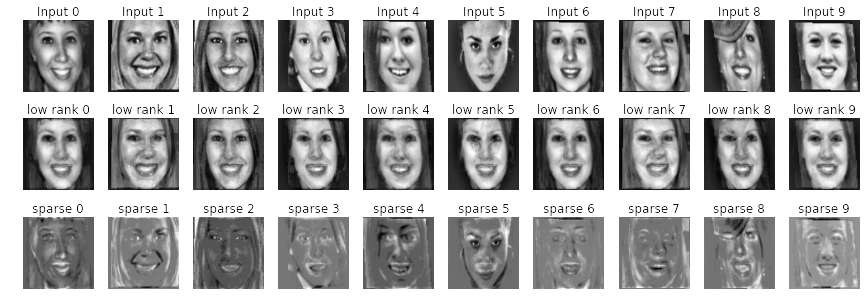

In [17]:

#########    
lamda = 0.4

low_rank, sparse, n_iter,rank, sparsity ,sparseness= rpca(Y,lamda)

 # Visualize and inspect
def showSlice(D, titleN,color,row, referenceIm=None):
     for i in range(D.shape[1]):
       im = np.array(D[:,i].reshape(x_dim,y_dim))
        
       plt.subplot2grid((3,D.shape[1]),(row,i))
       implot = plt.imshow(im,color)
       plt.axis('off')
       plt.title(titleN+' '+str(i))

fig = plt.figure(figsize=(15,5))
showSlice(Y, 'Input',cm.gray,0)    
showSlice(low_rank,'low rank',cm.gray,1)
showSlice(sparse,'sparse', cm.gray,2)# Testing ANTS registration, set parameters



In [18]:
def saveImagesFromDM(D, filePrefix):
    for i in range(num_of_data):
        im_array = np.array(D[:,i].reshape(x_dim, y_dim))
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,filePrefix +str(i)+ '.nrrd')
        
def averageImageFromDM(D, fileName):        
        m = np.average(D,1)
        atlas = m.reshape(x_dim,y_dim)
        im = sitk.GetImageFromArray(atlas)
        sitk.WriteImage(im,fileName)

traditional unbiased atlas over iterations:


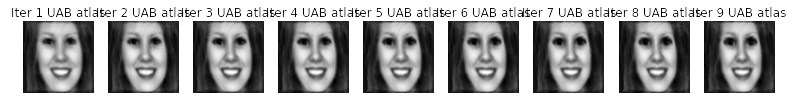

In [19]:
# traditional unbiased atlas building (UAB)
def runUABIteration(currentIter):
     
    atlasIm = UAB_result_folder + '/aver_UAB_iter'+str(currentIter-1)+'.nrrd'
    
    for i in range(num_of_data):
            initialInputImage = result_folder+'/Iter0_' +str(i) +  '.nrrd'
            newInputImage = UAB_result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'

            # deform with an intial moving transform from previous iteration
            initialTransform = None
            
            outputTransformPrefix = UAB_result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
            # usage: ANTS(fixedIm,movingIm,outputTransformPrefix,params,initialTransform=None, EXECUTE = False):
            cmd = ANTS(atlasIm, initialInputImage,outputTransformPrefix,antsParams, initialTransform, True)
            # Update input image to update the average image
            # ANTSWarp2DImage(inputIm, outputIm, referenceIm, transformPrefix,inverse = False, EXECUTE = False):
            ANTSWarp2DImage(initialInputImage,newInputImage, atlasIm,outputTransformPrefix, False,True)
          
   
    A = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data):
        #fn = UAB_result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        fn = UAB_result_folder+'/Iter'+ str(currentIter)+'_' +str(i)+'_Warped.nrrd'
        im_array = getImageArray(fn)
        A[:,i] = im_array.reshape(-1)
    newAtlasIm = UAB_result_folder + '/aver_UAB_iter'+str(currentIter)+'.nrrd'  
    averageImageFromDM(A,newAtlasIm)
        
    newAtlas = getImageArray(newAtlasIm)

    plt.subplot(1,NUM_OF_ITERATIONS,currentIter)
    plt.imshow(newAtlas, cm.gray)
    plt.title( 'Iter %s UAB atlas' %(currentIter))
    plt.axis('off')
          
       
    return


###################################### run  UAB #######################

Y = np.zeros((x_dim*y_dim,num_of_data))

for i in range(num_of_data):
    fn = result_folder+'/Iter0_'+str(i)+'.nrrd'
    im_array = getImageArray(fn)
    Y[:,i] = im_array.reshape(-1)
m = np.average(Y,1)
atlas = m.reshape(x_dim,y_dim)
#plt.imshow(atlas, cm.gray)
#plt.title('Euclidean mean of original inputs')
im = sitk.GetImageFromArray(atlas)
sitk.WriteImage(im,UAB_result_folder +'/aver_UAB_iter0.nrrd')

print 'traditional unbiased atlas over iterations:'
plt.figure(figsize=(15,5))
for k in range(1,NUM_OF_ITERATIONS):
    runUABIteration(k)


In [20]:
###############################  the main LAB (low-rank atlas building) pipeline #############################
        
def runLABIteration(currentIter, sigma):
    # run RPCA
    Y = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data) :
        im_file =  result_folder+'/'+ 'Iter'+str(currentIter - 1)+'_' + str(i)  + '.nrrd'  
        inIm = sitk.ReadImage(im_file)
        outIm = inIm
        if sigma > 0:
            srg = sitk.SmoothingRecursiveGaussianImageFilter()
            srg.SetSigma(sigma)
            outIm = srg.Execute(inIm)
        tmp = sitk.GetArrayFromImage(outIm)
        Y[:,i] = tmp.reshape(-1)
    
    low_rank, sparse, n_iter,rank, sparsity, sparseness = rpca(Y,lamda)
    saveImagesFromDM(low_rank,result_folder+'/'+ 'Iter'+str(currentIter) +'_LowRank_')
    saveImagesFromDM(sparse,result_folder+'/'+ 'Iter'+str(currentIter) +'_Sparse_')
    
    
    # visualize and inspect
    fig = plt.figure(figsize=(15,5))
    showSlice(Y, 'Iter'+str(currentIter) +' Input',cm.gray,0)    
    showSlice(low_rank,'Iter'+str(currentIter) +' low rank',cm.gray,1)
    showSlice(sparse,'Iter'+str(currentIter) +' sparse',cm.gray,2)
    savefig(result_folder+'/'+'Iter'+ str(currentIter)+'.jpg')
    
    
     # Compute the mean of low_rank as the atlas image
    atlasIm = result_folder + '/average_iter'+str(currentIter)+'.nrrd'
    if currentIter == 1 :
        averageImageFromDM(low_rank,atlasIm)     
    else:
        A = np.zeros((x_dim*y_dim,num_of_data))
        for i in range(num_of_data):
            # get inverse transformed low rank image
            lowRankIm = result_folder+'/'+ 'Iter'+str(currentIter)+'_LowRank_' + str(i)  +'.nrrd'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
            previousOutputTransformPrefix = result_folder+'/Iter'+ str(currentIter-1)+'_'+str(i)+'_'
            ANTSWarp2DImage(lowRankIm,invWarpedlowRankIm, lowRankIm,previousOutputTransformPrefix,True, True)
            tmp = getImageArray(lowRankIm)
            A[:,i] = tmp.reshape(-1)
        averageImageFromDM(A,atlasIm)
        
    atlas = getImageArray(atlasIm)
    #plt.figure()
    #plt.imshow(atlas, cm.gray)
    #plt.title( 'Iter %s atlas' %(currentIter))
          
   
    # register low-rank images to the atlas(average) image
    for i in range(num_of_data):
        newInputImage = result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        initialInputImage = result_folder+'/Iter0_' +str(i) +  '.nrrd'

        # deform with an intial moving transform from previous iteration
        initialTransform = None
        invWarpedlowRankIm = result_folder+'/'+ 'Iter1_LowRank_' + str(i)  +'.nrrd'
        if currentIter > 1:
            #initialTransform = result_folder + '/Iter'+str(currentIter-1)+'_'+str(i)+'_0Warp.nii.gz'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
        # register the inversely warped low rank image to the atlas image
        outputTransformPrefix = result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        cmd = ANTS(atlasIm, invWarpedlowRankIm,outputTransformPrefix,antsParams, initialTransform, True)
        #print cmd
        # Update input image for the next iteration
        ANTSWarp2DImage(initialInputImage,newInputImage, atlasIm,outputTransformPrefix, False,True)
       
    return
    

iter1
[iter: 0000]: rank(P) = 0002, |C|_0 = 0301, crit=0.2543051009, total sparse =2700
[iter: 0010]: rank(P) = 0010, |C|_0 = 45593, crit=0.0009110427, total sparse =1152757
[iter: 0020]: rank(P) = 0010, |C|_0 = 43763, crit=0.0000002180, total sparse =1108282
RPCA takes:0.216434 seconds
iter2
[iter: 0000]: rank(P) = 0002, |C|_0 = 0294, crit=0.2214375220, total sparse =2517
[iter: 0010]: rank(P) = 0010, |C|_0 = 47131, crit=0.0013336684, total sparse =1089568
[iter: 0020]: rank(P) = 0010, |C|_0 = 44706, crit=0.0000003327, total sparse =1039852
RPCA takes:0.285680 seconds
iter3
[iter: 0000]: rank(P) = 0002, |C|_0 = 0380, crit=0.2154789478, total sparse =3536
[iter: 0010]: rank(P) = 0010, |C|_0 = 47110, crit=0.0016048083, total sparse =1060486
[iter: 0020]: rank(P) = 0010, |C|_0 = 44479, crit=0.0000003853, total sparse =1009703
RPCA takes:0.336672 seconds
iter4
[iter: 0000]: rank(P) = 0002, |C|_0 = 0418, crit=0.2130554725, total sparse =3819
[iter: 0010]: rank(P) = 0010, |C|_0 = 47176, cri

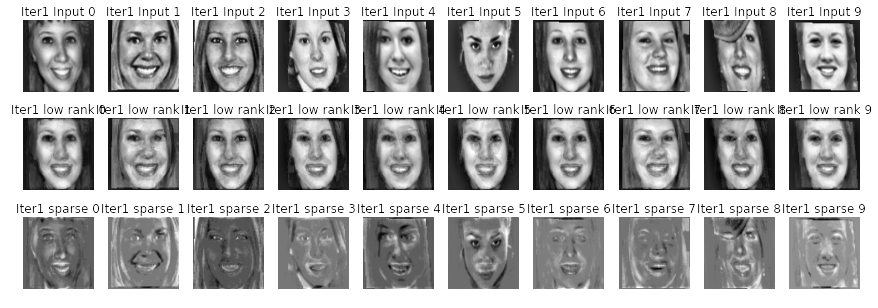

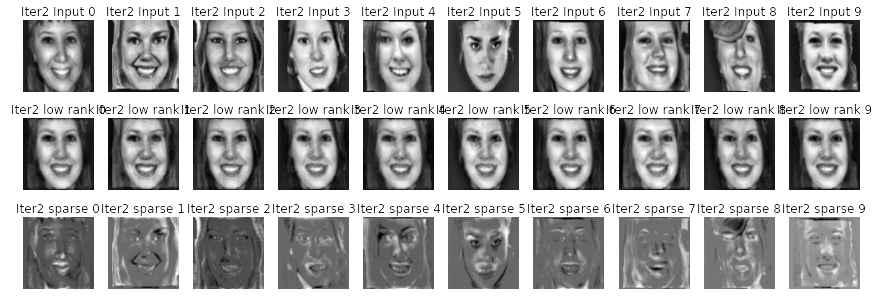

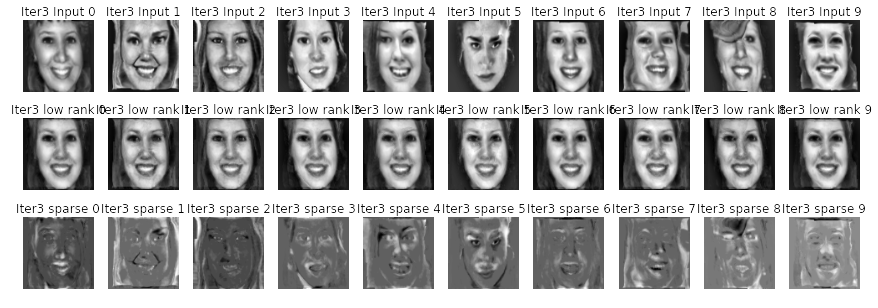

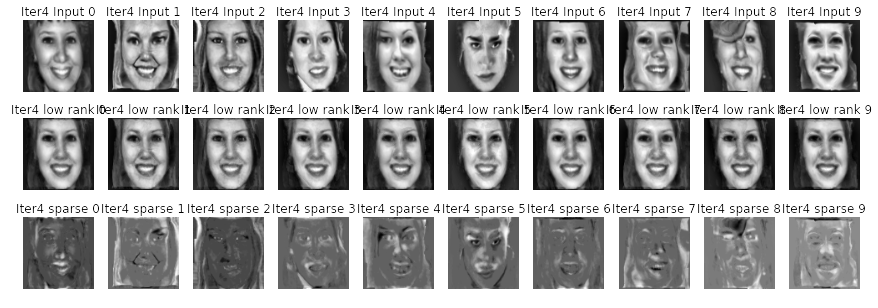

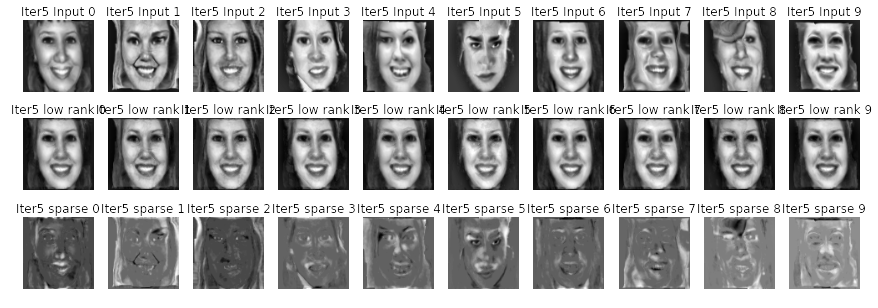

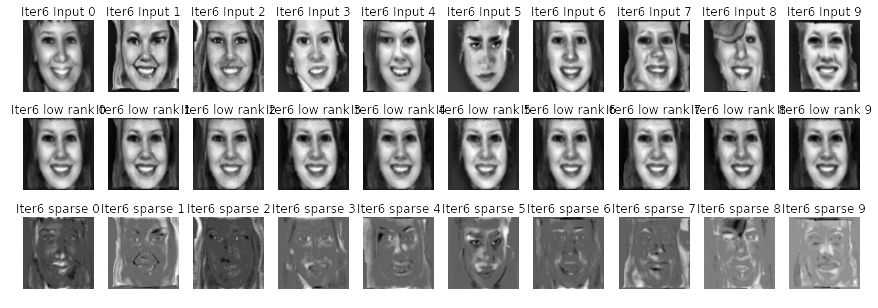

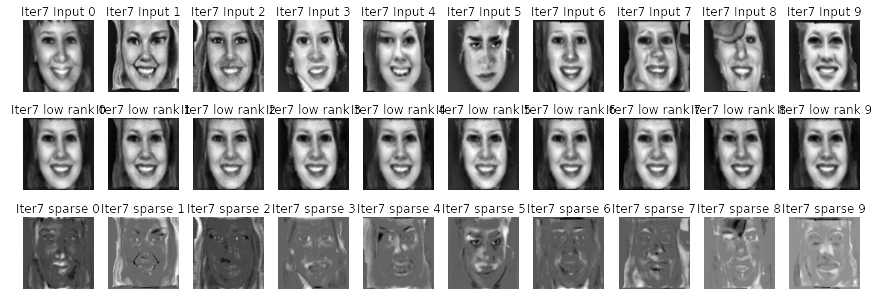

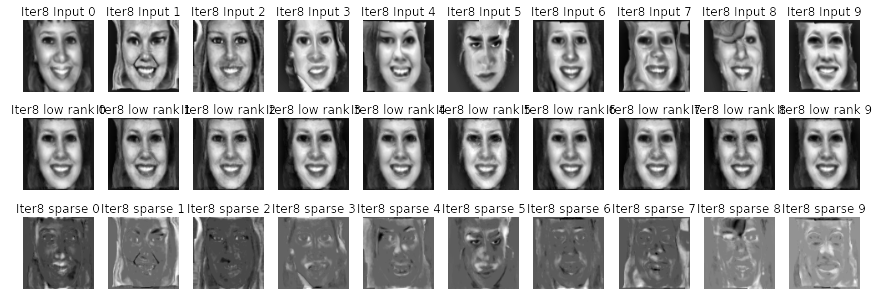

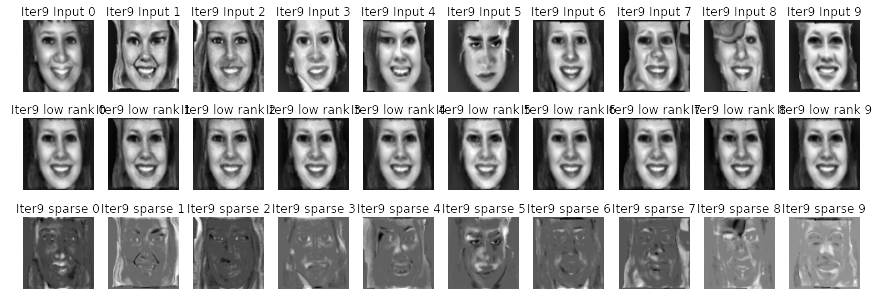

In [21]:
# main
sigma = 0

for k in range(1,NUM_OF_ITERATIONS):
    print 'iter'+str(k)
    runLABIteration(k,sigma) 
    

compare last iteration results


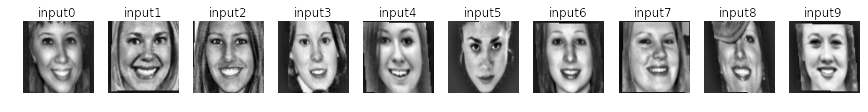

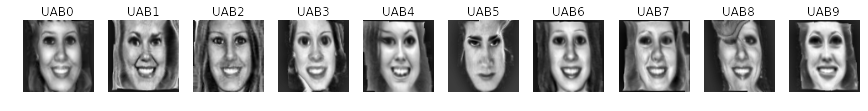

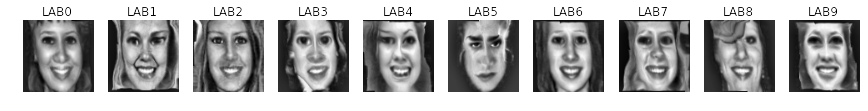

In [22]:
print 'compare last iteration results'
currentIter = NUM_OF_ITERATIONS-1


plt.figure(figsize=(15,5))
for i in range(num_of_data):
    fn = result_folder+'/Iter0_' +str(i) +  '.nrrd' 
    im_array = getImageArray(fn)
    plt.subplot(1,num_of_data,i+1)
    plt.imshow(im_array,cm.gray) 
    plt.title( 'input'+str(i))
    plt.axis('off') 

plt.figure(figsize=(15,5))
for i in range(num_of_data):
    fn = UAB_result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd' 
    im_array = getImageArray(fn)
    plt.subplot(1,num_of_data,i+1)
    plt.imshow(im_array,cm.gray) 
    plt.title( 'UAB'+str(i))
    plt.axis('off') 
    
plt.figure(figsize=(15,5))
for i in range(num_of_data):
    fn = result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
    im_array = getImageArray(fn)
    plt.subplot(1,num_of_data,i+1)
    plt.imshow(im_array,cm.gray) 
    plt.title( 'LAB'+str(i))
    plt.axis('off') 



 low-rank atlas over iterations


(-0.5, 85.5, 85.5, -0.5)

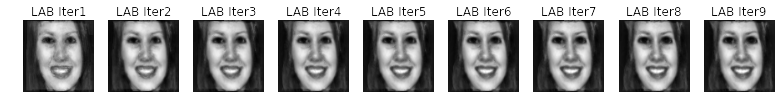

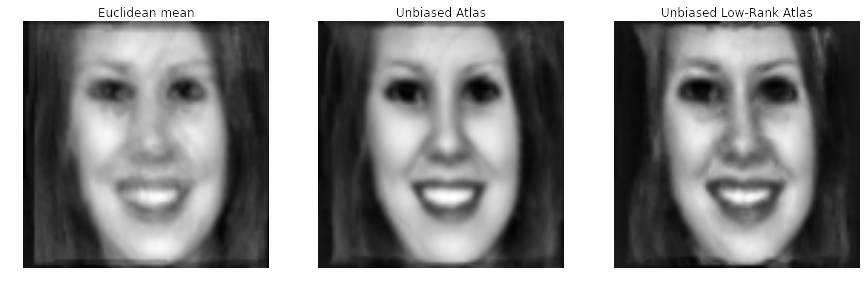

In [23]:
# compare results with traditional UAB
print " low-rank atlas over iterations"
plt.figure(figsize=(15,5))
for currentIter in range(1,NUM_OF_ITERATIONS):
    fn = result_folder+ '/average_iter'+ str(currentIter) +'.nrrd'
    im_array = getImageArray(fn)
    plt.subplot(1,NUM_OF_ITERATIONS,currentIter)
    plt.imshow(im_array,cm.gray) 
    plt.axis('off') 
    plt.title( 'LAB Iter'+str(currentIter))

    
plt.figure(figsize=(15,5))
fn = UAB_result_folder +'/aver_UAB_iter0.nrrd'
im_array = getImageArray(fn)
plt.subplot(1,3,1)
plt.imshow(im_array, cm.gray)
plt.axis('off') 
plt.title('Euclidean mean')



fn = UAB_result_folder + '/aver_UAB_iter'+str(3)+'.nrrd'
im_array = getImageArray(fn)
plt.subplot(1,3,2)
implot = plt.imshow(im_array,cm.gray) 
plt.title('Unbiased Atlas')
plt.axis('off') 


fn = result_folder + '/average_iter'+str(NUM_OF_ITERATIONS-1)+'.nrrd'
im_array = getImageArray(fn)
plt.subplot(1,3,3)
implot = plt.imshow(im_array,cm.gray) 
plt.title('Unbiased Low-Rank Atlas')
plt.axis('off')  
